In [2]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import ABSATokenizer
import utils.utils as utils

In [2]:
tokenizer = ABSATokenizer.from_pretrained("bert-base-multilingual-cased")

In [3]:
path = "E:/TFM_CCIL/opensubtitles/"

In [46]:
all_lengths = {}

In [48]:
for lang in tqdm(os.listdir(path)):
    if lang not in all_lengths.keys():
        difs = []
        en_path = glob.glob(path + "{0}/*.en".format(lang))[0]
        other_path = glob.glob(path + "{0}/*.{0}".format(lang))[0]
        prev_means = np.array([1e5] * 20)

        with open(en_path, encoding="utf-8") as file_en, open(other_path, encoding="utf-8") as file_other:
            for _ in tqdm(range(5000000)):
                try:
                    line_en = next(file_en)
                    line_other = next(file_other)
                except StopIteration:
                    break
                length_en = len(tokenizer.encode(line_en, add_special_tokens=False))
                length_other = len(tokenizer.encode(line_other, add_special_tokens=False))
                dif = (length_other - length_en) / length_en * 100
                difs.append(dif)
                if not _ % 10000:
                    current_mean = np.mean(difs)
                    if np.mean(np.abs((prev_means - np.concatenate((prev_means, [current_mean]))[1:]) / prev_means)) < 0.001:
                        break
                    prev_means = np.concatenate((prev_means[1:], [current_mean]))
        all_lengths[lang] = np.mean(difs)

e:\anaconda\envs\tfm_ccil\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


In [50]:
all_lengths["en"] = 0

In [51]:
table = pd.DataFrame.from_dict(all_lengths, orient="index").reset_index().rename(columns={"index": "Language", 
                                                                                          0: "Relative Difference (%)"})

In [52]:
code_to_name = utils.make_lang_code_dicts()["code_to_name"]

In [53]:
table = table.replace(code_to_name)
table = utils.order_table(table)

Other info and export latex

In [3]:
table = pd.read_excel("relative_lengths.xlsx")

In [4]:
for task in ["pos", "sentiment"]:
    table = pd.merge(table, pd.read_excel("{}_basic_stats.xlsx".format(task))[["language", "test_avg_tokens"]],
                     left_on="Language", right_on="language", how="left").drop("language", axis=1).rename(
        columns={"test_avg_tokens": "test_avg_tokens_{}".format(task)}
    )

In [5]:
for task in ["pos", "sentiment"]:
    table["expected_length_{}".format(task)] = (1 + table["Relative Difference (%)"] / 100) \
                                    * table.loc[table["Language"] == "English", "test_avg_tokens_{}".format(task)].values[0]
    table["difference_expected_{}".format(task)] = table["test_avg_tokens_{}".format(task)] \
                                    - table["expected_length_{}".format(task)]
    if task == "sentiment":
        table.loc[table["Language"].isin(["Russian", "Japanese", "Turkish"]), 
                  [col for col in table.columns if "sentiment" in  col]] = np.nan

In [6]:
table = table[table.columns[:2].tolist() + [col for col in table.columns if "pos" in col] + \
              [col for col in table.columns if "sentiment" in col]]

In [7]:
table = table.round(1)
table = table.replace(np.nan, "-")
table

,Language,Relative Difference (%),test_avg_tokens_pos,expected_length_pos,difference_expected_pos,test_avg_tokens_sentiment,expected_length_sentiment,difference_expected_sentiment
0,Bulgarian,30.5,26.2,31.8,-5.6,19.4,36,-16.6
1,English,0.0,24.4,24.4,0.0,27.6,27.6,0
2,Russian,28.7,33.8,31.4,2.4,-,-,-
3,Slovak,28.9,25.0,31.5,-6.5,34.9,35.6,-0.7
4,Croatian,14.4,38.0,27.9,10.0,51.8,31.6,20.2
5,Chinese,15.0,33.6,28.0,5.6,80.2,31.7,48.4
6,Vietnamese,25.1,20.8,30.5,-9.7,37.4,34.5,2.9
7,Thai,110.2,69.4,51.3,18.1,56.4,58,-1.6
8,Finnish,12.3,33.8,27.4,6.4,92.5,31,61.5
9,Basque,19.2,26.1,29.1,-3.0,20.7,32.9,-12.2


In [26]:
utils.convert_table_to_latex(table)

\fusional{Fusional} & Bulgarian & 30.5 & 26.2 & 31.8 & -5.6 & 19.4 & 36.0 & -16.6\\
\fusional{Fusional} & English & 0.0 & 24.4 & 24.4 & 0.0 & 27.6 & 27.6 & 0.0\\
\fusional{Fusional} & Russian & 28.7 & 33.8 & 31.4 & 2.4 & - & - & -\\
\fusional{Fusional} & Slovak & 28.9 & 25.0 & 31.5 & -6.5 & 34.9 & 35.6 & -0.7\\
\fusional{Fusional} & Croatian & 14.4 & 38.0 & 27.9 & 10.0 & 51.8 & 31.6 & 20.2\\
\isolating{Isolating} & Chinese & 15.0 & 33.6 & 28.0 & 5.6 & 80.2 & 31.7 & 48.4\\
\isolating{Isolating} & Vietnamese & 25.1 & 20.8 & 30.5 & -9.7 & 37.4 & 34.5 & 2.9\\
\isolating{Isolating} & Thai & 110.2 & 69.4 & 51.3 & 18.1 & 56.4 & 58.0 & -1.6\\
\agglutinative{Agglutinative} & Finnish & 12.3 & 33.8 & 27.4 & 6.4 & 92.5 & 31.0 & 61.5\\
\agglutinative{Agglutinative} & Basque & 19.2 & 26.1 & 29.1 & -3.0 & 20.7 & 32.9 & -12.2\\
\agglutinative{Agglutinative} & Japanese & 13.0 & 41.7 & 27.6 & 14.1 & - & - & -\\
\agglutinative{Agglutinative} & Korean & 20.5 & 33.4 & 29.4 & 4.0 & 43.0 & 33.2 & 9.8\\
\aggl

,group,Language,Relative Difference (%),test_avg_tokens_pos,expected_length_pos,difference_expected_pos,test_avg_tokens_sentiment,expected_length_sentiment,difference_expected_sentiment
0,\fusional{Fusional},Bulgarian,30.5,26.2,31.8,-5.6,19.4,36,-16.6
1,\fusional{Fusional},English,0.0,24.4,24.4,0.0,27.6,27.6,0
2,\fusional{Fusional},Russian,28.7,33.8,31.4,2.4,-,-,-
3,\fusional{Fusional},Slovak,28.9,25.0,31.5,-6.5,34.9,35.6,-0.7
4,\fusional{Fusional},Croatian,14.4,38.0,27.9,10.0,51.8,31.6,20.2
5,\isolating{Isolating},Chinese,15.0,33.6,28.0,5.6,80.2,31.7,48.4
6,\isolating{Isolating},Vietnamese,25.1,20.8,30.5,-9.7,37.4,34.5,2.9
7,\isolating{Isolating},Thai,110.2,69.4,51.3,18.1,56.4,58,-1.6
8,\agglutinative{Agglutinative},Finnish,12.3,33.8,27.4,6.4,92.5,31,61.5
9,\agglutinative{Agglutinative},Basque,19.2,26.1,29.1,-3.0,20.7,32.9,-12.2


### Plots

In [39]:
df = pd.read_excel("relative_lengths.xlsx")

In [40]:
df = pd.concat([df, pd.read_excel("pos_basic_stats.xlsx")["train_examples"], 
                pd.read_excel("../results/pos_within_cross_accuracy.xlsx")["PUD"]], axis=1)

In [41]:
df = utils.add_lang_groups(df, "Group")

In [42]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

In [46]:
df = df.rename(columns={"train_examples": "train-examples", "difference_expected_pos": "difference-expected-pos"})

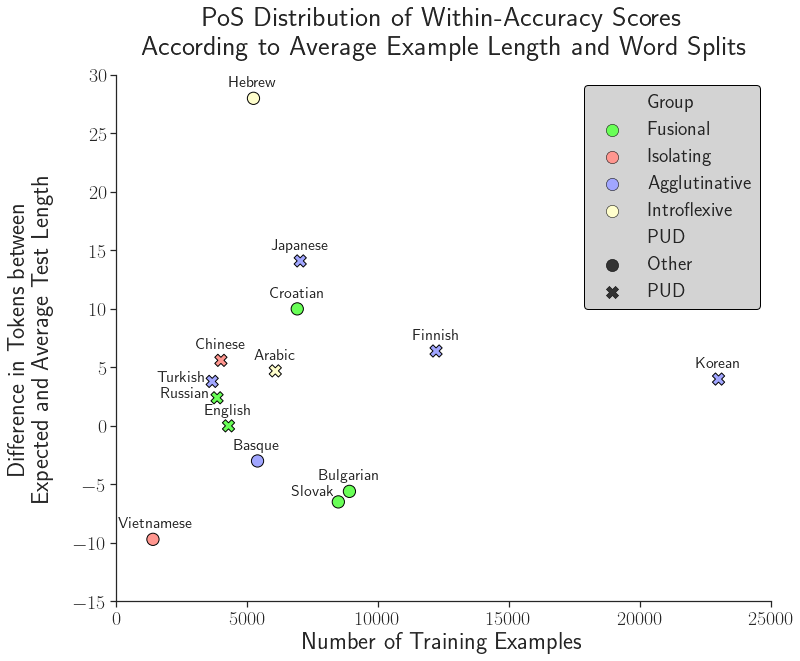

In [117]:
from matplotlib.patches import Patch

colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

data = df[df["Language"] != "Thai"]
x = "train-examples"
y = "difference-expected-pos"
hue = "Group"
langs = "Language"

offsets = dict.fromkeys(data[langs].values, (0,1))
offsets["Slovak"] = (-1000, 0.5)
offsets["Russian"] = (-1200, 0)
offsets["Turkish"] = (-1200, 0)
offsets["Vietnamese"] = (100, 1)

g = sns.relplot(x=x, y=y, data=data, hue=hue, palette=colors, legend="full", style="PUD",
                height=8, aspect=1.25, edgecolor="black", s=150)

for i, row in data.iterrows():
    plt.text(row[x] + offsets[row[langs]][0], row[y] + offsets[row[langs]][1], 
             row[langs], fontsize=16, horizontalalignment="center")
    
leg = g._legend
leg.set_visible(False)
    
leg = plt.legend(loc="upper left", bbox_to_anchor=(0.7, 1), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
                 framealpha=1, edgecolor="black", labelspacing=0.4)

for handle in leg.legendHandles:
    handle.set_sizes([150])
    handle.set_lw(0.5)
    handle.set_edgecolor("black")

plt.ylim((-15,30))
plt.xlim((0,25000))
plt.ylabel("Difference in Tokens between\nExpected and Average Test Length", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Number of Training Examples", fontsize=24 +  extra_fontsize)
plt.title("PoS Distribution of Within-Accuracy Scores \n According to Average Example Length and Word Splits", 
          fontsize=28 +  extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_length_word_splits_within_accuracy.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [114]:
leg.legendHandles

In [101]:
a = leg.legendHandles[0]

In [122]:
leg.get_legend_handler_map()

{matplotlib.container.StemContainer: <matplotlib.legend_handler.HandlerStem at 0x17a370080>,
 matplotlib.container.ErrorbarContainer: <matplotlib.legend_handler.HandlerErrorbar at 0x17a3700b8>,
 matplotlib.lines.Line2D: <matplotlib.legend_handler.HandlerLine2D at 0x17a3700f0>,
 matplotlib.patches.Patch: <matplotlib.legend_handler.HandlerPatch at 0x17a38fa58>,
 matplotlib.collections.LineCollection: <matplotlib.legend_handler.HandlerLineCollection at 0x17a38ff98>,
 matplotlib.collections.RegularPolyCollection: <matplotlib.legend_handler.HandlerRegularPolyCollection at 0x17a37b908>,
 matplotlib.collections.CircleCollection: <matplotlib.legend_handler.HandlerCircleCollection at 0x17a37b940>,
 matplotlib.container.BarContainer: <matplotlib.legend_handler.HandlerPatch at 0x17a37b978>,
 tuple: <matplotlib.legend_handler.HandlerTuple at 0x17a37b9b0>,
 matplotlib.collections.PathCollection: <matplotlib.legend_handler.HandlerPathCollection at 0x17a37b9e8>,
 matplotlib.collections.PolyCollection